# SECTION 1: DECLARE THE MODULES

In [18]:
import os
from collections import defaultdict
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

# SECTION 2: Data import and preprocess
#Run this but dont worry if it does not make any sense Jump to SECTION 3 that is related to your HD task.

In [19]:
!pip install wget
import wget

link_to_data = 'https://raw.githubusercontent.com/SIT719/2020-S2/master/data/Week_5_NSL-KDD-Dataset/training_attack_types.txt?raw=true'
DataSet = wget.download(link_to_data)
DataSet

'training_attack_types (1).txt'

In [20]:
header_names = ['duration', 'protocol_type', 'service', 'flag', 'src_bytes', 'dst_bytes', 'land', 'wrong_fragment', 'urgent', 'hot', 'num_failed_logins', 'logged_in', 'num_compromised', 'root_shell', 'su_attempted', 'num_root', 'num_file_creations', 'num_shells', 'num_access_files', 'num_outbound_cmds', 'is_host_login', 'is_guest_login', 'count', 'srv_count', 'serror_rate', 'srv_serror_rate', 'rerror_rate', 'srv_rerror_rate', 'same_srv_rate', 'diff_srv_rate', 'srv_diff_host_rate', 'dst_host_count', 'dst_host_srv_count', 'dst_host_same_srv_rate', 'dst_host_diff_srv_rate', 'dst_host_same_src_port_rate', 'dst_host_srv_diff_host_rate', 'dst_host_serror_rate', 'dst_host_srv_serror_rate', 'dst_host_rerror_rate', 'dst_host_srv_rerror_rate', 'attack_type', 'success_pred']

# Differentiating between nominal, binary, and numeric features

# root_shell is marked as a continuous feature in the kddcup.names
# file, but it is supposed to be a binary feature according to the
# dataset documentation

# training_attack_types.txt maps each of the 22 different attacks to 1 of 4 categories
# file obtained from http://kdd.ics.uci.edu/databases/kddcup99/training_attack_types

col_names = np.array(header_names)

nominal_idx = [1, 2, 3]
binary_idx = [6, 11, 13, 14, 20, 21]
numeric_idx = list(set(range(41)).difference(nominal_idx).difference(binary_idx))

nominal_cols = col_names[nominal_idx].tolist()
binary_cols = col_names[binary_idx].tolist()
numeric_cols = col_names[numeric_idx].tolist()

In [21]:
# training_attack_types.txt maps each of the 22 different attacks to 1 of 4 categories
# file obtained from http://kdd.ics.uci.edu/databases/kddcup99/training_attack_types

category = defaultdict(list)
category['benign'].append('normal')

with open(DataSet, 'r') as f:
    for line in f.readlines():
        attack, cat = line.strip().split(' ')
        category[cat].append(attack)

attack_mapping = dict((v,k) for k in category for v in category[k])

In [22]:
attack_mapping

{'normal': 'benign',
 'apache2': 'dos',
 'back': 'dos',
 'mailbomb': 'dos',
 'processtable': 'dos',
 'snmpgetattack': 'dos',
 'teardrop': 'dos',
 'smurf': 'dos',
 'land': 'dos',
 'neptune': 'dos',
 'pod': 'dos',
 'udpstorm': 'dos',
 'ps': 'u2r',
 'buffer_overflow': 'u2r',
 'perl': 'u2r',
 'rootkit': 'u2r',
 'loadmodule': 'u2r',
 'xterm': 'u2r',
 'sqlattack': 'u2r',
 'httptunnel': 'u2r',
 'ftp_write': 'r2l',
 'guess_passwd': 'r2l',
 'snmpguess': 'r2l',
 'imap': 'r2l',
 'spy': 'r2l',
 'warezclient': 'r2l',
 'warezmaster': 'r2l',
 'multihop': 'r2l',
 'phf': 'r2l',
 'named': 'r2l',
 'sendmail': 'r2l',
 'xlock': 'r2l',
 'xsnoop': 'r2l',
 'worm': 'probe',
 'nmap': 'probe',
 'ipsweep': 'probe',
 'portsweep': 'probe',
 'satan': 'probe',
 'mscan': 'probe',
 'saint': 'probe'}

In [23]:
#Processing Training Data

train_file='https://raw.githubusercontent.com/SIT719/2020-S2/master/data/Week_5_NSL-KDD-Dataset/KDDTrain%2B.txt'

train_df = pd.read_csv(train_file, names=header_names)
train_df['attack_category'] = train_df['attack_type'].map(lambda x: attack_mapping[x])

train_df.drop(['success_pred'], axis=1, inplace=True)

In [24]:
#Processing test Data
test_file='https://raw.githubusercontent.com/SIT719/2020-S2/master/data/Week_5_NSL-KDD-Dataset/KDDTest%2B.txt'

test_df = pd.read_csv(test_file, names=header_names)
test_df['attack_category'] = test_df['attack_type'] \
                                .map(lambda x: attack_mapping[x])
test_df.drop(['success_pred'], axis=1, inplace=True)

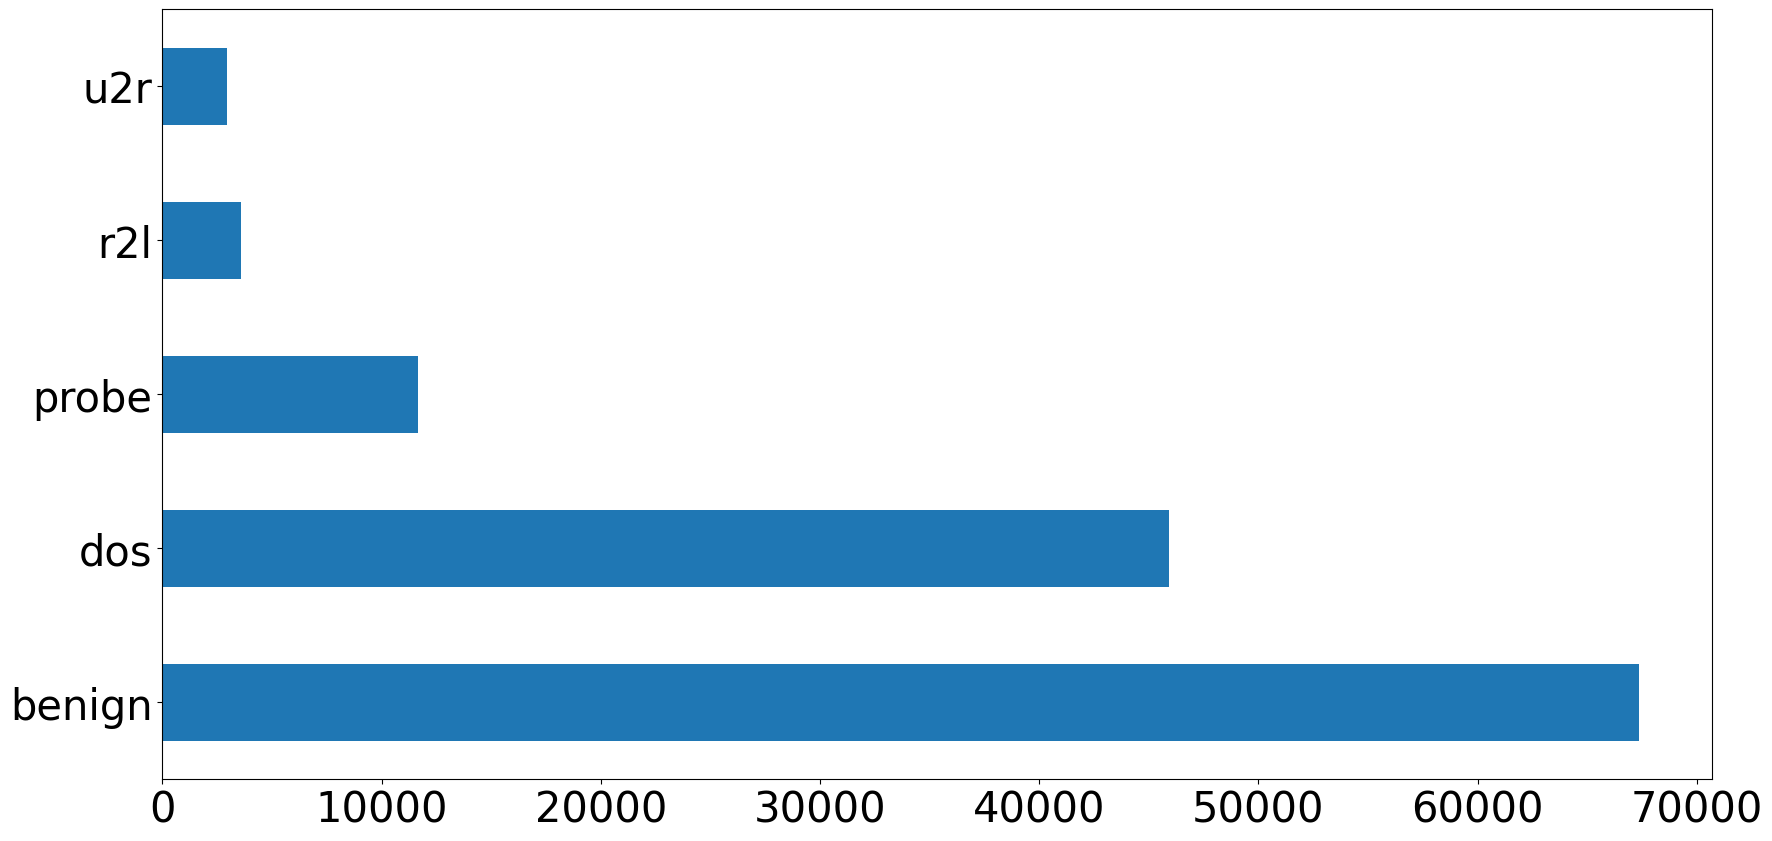

In [25]:
train_attack_types = train_df['attack_type'].value_counts()
train_attack_cats = train_df['attack_category'].value_counts()

test_attack_types = test_df['attack_type'].value_counts()
test_attack_cats = test_df['attack_category'].value_counts()

train_attack_types.plot(kind='barh', figsize=(20,10), fontsize=20)

train_attack_cats.plot(kind='barh', figsize=(20,10), fontsize=30)

train_df[binary_cols].describe().transpose()
train_df.groupby(['su_attempted']).size()
train_df['su_attempted'].replace(2, 0, inplace=True)
test_df['su_attempted'].replace(2, 0, inplace=True)
train_df.groupby(['su_attempted']).size()
train_df.groupby(['num_outbound_cmds']).size()

#Now, that's not a very useful feature - let's drop it from the dataset

train_df.drop('num_outbound_cmds', axis = 1, inplace=True)
test_df.drop('num_outbound_cmds', axis = 1, inplace=True)
numeric_cols.remove('num_outbound_cmds')

#Data Preparation

train_Y = train_df['attack_category']
train_x_raw = train_df.drop(['attack_category','attack_type'], axis=1)
test_Y = test_df['attack_category']
test_x_raw = test_df.drop(['attack_category','attack_type'], axis=1)


combined_df_raw = pd.concat([train_x_raw, test_x_raw])
combined_df = pd.get_dummies(combined_df_raw, columns=nominal_cols, drop_first=True)

train_x = combined_df[:len(train_x_raw)]
test_x = combined_df[len(train_x_raw):]

# Store dummy variable feature names
dummy_variables = list(set(train_x)-set(combined_df_raw))

#execute the commands in console
train_x.describe()
train_x['duration'].describe()
# Experimenting with StandardScaler on the single 'duration' feature
from sklearn.preprocessing import StandardScaler

durations = train_x['duration'].values.reshape(-1, 1)
standard_scaler = StandardScaler().fit(durations)
scaled_durations = standard_scaler.transform(durations)
pd.Series(scaled_durations.flatten()).describe()

# Experimenting with MinMaxScaler on the single 'duration' feature
from sklearn.preprocessing import MinMaxScaler

min_max_scaler = MinMaxScaler().fit(durations)
min_max_scaled_durations = min_max_scaler.transform(durations)
pd.Series(min_max_scaled_durations.flatten()).describe()

# Experimenting with RobustScaler on the single 'duration' feature
from sklearn.preprocessing import RobustScaler

min_max_scaler = RobustScaler().fit(durations)
robust_scaled_durations = min_max_scaler.transform(durations)
pd.Series(robust_scaled_durations.flatten()).describe()

# Experimenting with MaxAbsScaler on the single 'duration' feature
from sklearn.preprocessing import MaxAbsScaler

max_Abs_scaler = MaxAbsScaler().fit(durations)
robust_scaled_durations = max_Abs_scaler.transform(durations)
pd.Series(robust_scaled_durations.flatten()).describe()

# Let's proceed with StandardScaler- Apply to all the numeric columns
standard_scaler = StandardScaler().fit(train_x[numeric_cols])

train_x[numeric_cols] = \
    standard_scaler.transform(train_x[numeric_cols])

test_x[numeric_cols] = \
    standard_scaler.transform(test_x[numeric_cols])

train_x.describe()

train_Y_bin = train_Y.apply(lambda x: 0 if x is 'benign' else 1)
test_Y_bin = test_Y.apply(lambda x: 0 if x is 'benign' else 1)

In [26]:
# Attack classes
print(len(np.unique(train_Y)))
print(np.unique(train_Y))

5
['benign' 'dos' 'probe' 'r2l' 'u2r']


# SECTION 3: Multi class classification
#This is the section where you have to add other algorithms, tune algorithms and visualize to compare and analyze algorithms

In [27]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import confusion_matrix, zero_one_loss, accuracy_score, f1_score, precision_score, recall_score, multilabel_confusion_matrix, classification_report, ConfusionMatrixDisplay
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

performance_metrics = {}
label_names = np.unique(train_Y)

###Encoding Data

In [28]:
label_encoder = LabelEncoder()
train_Y_encoded = label_encoder.fit_transform(train_Y)
test_Y_encoded = label_encoder.transform(test_Y)

onehot_encoder = OneHotEncoder(sparse=False)

train_Y_encoded = onehot_encoder.fit_transform(train_Y_encoded.reshape(-1, 1))
test_Y_encoded = onehot_encoder.transform(test_Y_encoded.reshape(-1, 1))

###Utility Functions

In [29]:
def print_analysis_report(y_pred, class_name):
  # Metrics Calculation
  performance_metrics[class_name] = {}
  accuracy = accuracy_score(test_Y, y_pred)
  performance_metrics[class_name]['accuracy'] = accuracy
  conf_matx = confusion_matrix(test_Y, y_pred)
  f1score = f1_score(test_Y, y_pred, average="macro")
  performance_metrics[class_name]['f1score'] = f1score
  precision = precision_score(test_Y, y_pred, average="macro")
  performance_metrics[class_name]['precision'] = precision
  recall = recall_score(test_Y, y_pred, average="macro")
  performance_metrics[class_name]['recall'] = recall
  specificity = precision / (precision + recall)
  FAR = 1-specificity
  performance_metrics[class_name]['FAR'] = FAR
  print(f"""F-Score: {f1score}
        Precision: {precision}
        Re-call: {recall}
        Accuracy: {accuracy}
        False Alarm: {FAR}
        Confusion Matrix:\n{conf_matx}""")

  # Class-wise Metrics
  clrp = classification_report(test_Y, y_pred, target_names = label_names)
  print(clrp)

  performance_metrics[class_name]['class_FAR'] = {}
  # False Alarm Calculation
  for i, label_name in enumerate(label_names):
    TP = conf_matx[i, i]
    FP = np.sum(conf_matx[:, i]) - TP
    FN = np.sum(conf_matx[i, :]) - TP
    TN = np.sum(conf_matx) - TP - FP - FN
    false_alarm = FP / (FP + TN)
    performance_metrics[class_name]['class_FAR'][label_name] = false_alarm
    print(f"False Alarm of {label_name}: {false_alarm:.4f}\n")

  # Plot Confusion Matrix
  disp = ConfusionMatrixDisplay(confusion_matrix=conf_matx,display_labels=label_names)
  disp.plot()
  plt.show()

In [30]:
def analysis(class_type, **kwargs):
  classifier = class_type(**kwargs)
  classifier.fit(train_x, train_Y)

  y_pred = classifier.predict(test_x)
  print_analysis_report(y_pred, classifier.__class__.__name__)

#LinearDiscriminantAnalysis

F-Score: 0.5751300598759039
        Precision: 0.7619943418359932
        Re-call: 0.5456508191748052
        Accuracy: 0.755722143364088
        False Alarm: 0.417277435380881
        Confusion Matrix:
[[9258   85  334   18   16]
 [1497 5605  534    0    0]
 [ 564  228 1631    0    0]
 [2048    1    7  509    9]
 [ 158    0    0    8   34]]
              precision    recall  f1-score   support

      benign       0.68      0.95      0.80      9711
         dos       0.95      0.73      0.83      7636
       probe       0.65      0.67      0.66      2423
         r2l       0.95      0.20      0.33      2574
         u2r       0.58      0.17      0.26       200

    accuracy                           0.76     22544
   macro avg       0.76      0.55      0.58     22544
weighted avg       0.80      0.76      0.73     22544

False Alarm of benign: 0.3325

False Alarm of dos: 0.0211

False Alarm of probe: 0.0435

False Alarm of r2l: 0.0013

False Alarm of u2r: 0.0011



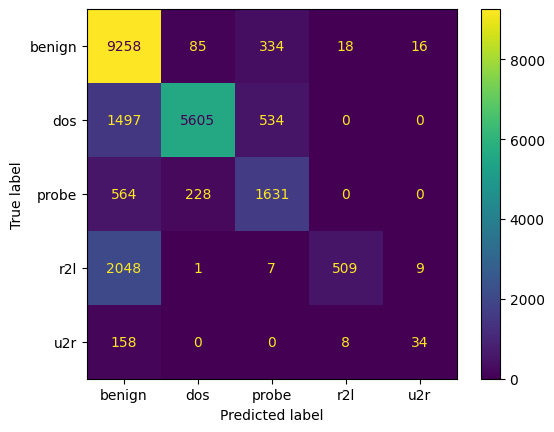

In [31]:
analysis(LinearDiscriminantAnalysis)

#SVC

F-Score: 0.5383925005210832
        Precision: 0.7955882223967755
        Re-call: 0.516463977320082
        Accuracy: 0.7584279630943932
        False Alarm: 0.39363066304186334
        Confusion Matrix:
[[9040  225  437    4    5]
 [1445 6179   12    0    0]
 [ 720  115 1588    0    0]
 [2291    1    2  275    5]
 [ 180    1    0    3   16]]
              precision    recall  f1-score   support

      benign       0.66      0.93      0.77      9711
         dos       0.95      0.81      0.87      7636
       probe       0.78      0.66      0.71      2423
         r2l       0.98      0.11      0.19      2574
         u2r       0.62      0.08      0.14       200

    accuracy                           0.76     22544
   macro avg       0.80      0.52      0.54     22544
weighted avg       0.81      0.76      0.73     22544

False Alarm of benign: 0.3613

False Alarm of dos: 0.0229

False Alarm of probe: 0.0224

False Alarm of r2l: 0.0004

False Alarm of u2r: 0.0004



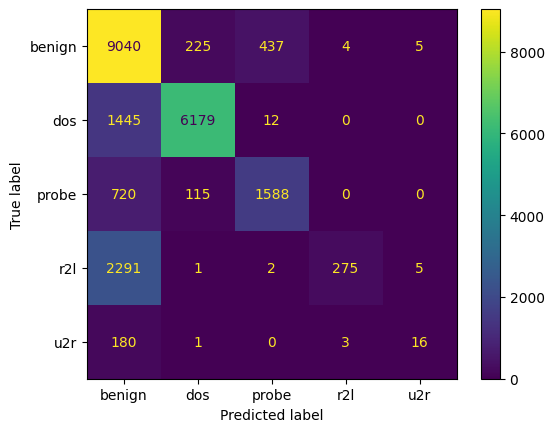

In [32]:
analysis(SVC,kernel='linear')

#DecisionTreeClassifier

F-Score: 0.5365861982591748
        Precision: 0.8363211675020017
        Re-call: 0.5124544931839992
        Accuracy: 0.7621096522356281
        False Alarm: 0.3799404957555059
        Confusion Matrix:
[[9365   56  289    1    0]
 [1541 5998   97    0    0]
 [ 677  220 1526    0    0]
 [2278    1   14  277    4]
 [ 175    0    5    5   15]]
              precision    recall  f1-score   support

      benign       0.67      0.96      0.79      9711
         dos       0.96      0.79      0.86      7636
       probe       0.79      0.63      0.70      2423
         r2l       0.98      0.11      0.19      2574
         u2r       0.79      0.07      0.14       200

    accuracy                           0.76     22544
   macro avg       0.84      0.51      0.54     22544
weighted avg       0.81      0.76      0.73     22544

False Alarm of benign: 0.3640

False Alarm of dos: 0.0186

False Alarm of probe: 0.0201

False Alarm of r2l: 0.0003

False Alarm of u2r: 0.0002



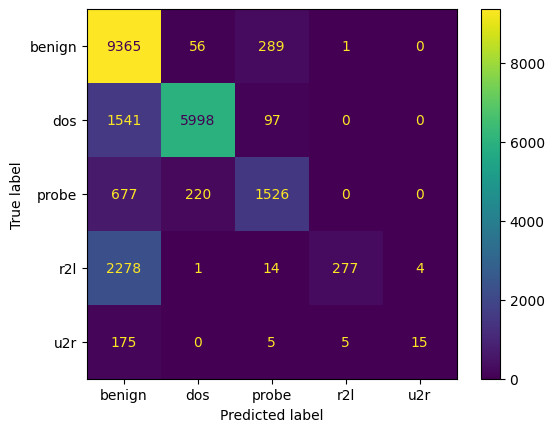

In [33]:
analysis(DecisionTreeClassifier, random_state=17)

#KNeighborsClassifier

F-Score: 0.5196654360220211
        Precision: 0.8601556370245385
        Re-call: 0.5063574671667119
        Accuracy: 0.7619322214336409
        False Alarm: 0.3705470994852931
        Confusion Matrix:
[[9444   54  207    5    1]
 [1630 5925   81    0    0]
 [ 614  180 1629    0    0]
 [2362    2   40  170    0]
 [ 170    0   17    4    9]]
              precision    recall  f1-score   support

      benign       0.66      0.97      0.79      9711
         dos       0.96      0.78      0.86      7636
       probe       0.83      0.67      0.74      2423
         r2l       0.95      0.07      0.12      2574
         u2r       0.90      0.04      0.09       200

    accuracy                           0.76     22544
   macro avg       0.86      0.51      0.52     22544
weighted avg       0.82      0.76      0.73     22544

False Alarm of benign: 0.3722

False Alarm of dos: 0.0158

False Alarm of probe: 0.0171

False Alarm of r2l: 0.0005

False Alarm of u2r: 0.0000



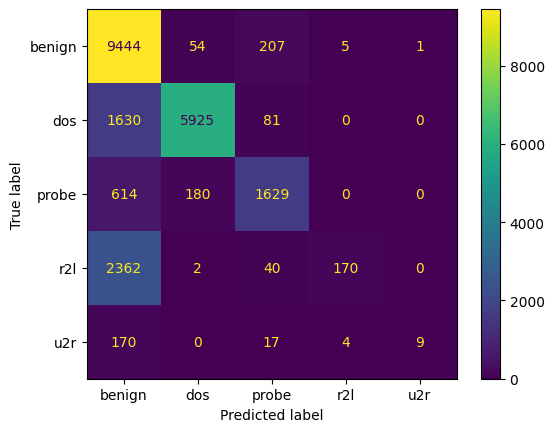

In [34]:
analysis(KNeighborsClassifier, n_neighbors = 5)

###Utility Function Multilabel

In [37]:
def print_analysis_report2(y_pred, class_name):
  # Metrics Calculation
  performance_metrics[class_name] = {}

  accuracy = accuracy_score(test_Y_encoded, y_pred)
  performance_metrics[class_name]['accuracy'] = accuracy
  conf_matx = multilabel_confusion_matrix(test_Y_encoded, y_pred)
  f1score = f1_score(test_Y_encoded, y_pred, average="macro")
  performance_metrics[class_name]['f1score'] = f1score
  precision = precision_score(test_Y_encoded, y_pred, average="macro")
  performance_metrics[class_name]['precision'] = precision
  recall = recall_score(test_Y_encoded, y_pred, average="macro")
  performance_metrics[class_name]['recall'] = recall
  specificity = precision / (precision + recall)
  FAR = 1-specificity
  performance_metrics[class_name]['FAR'] = FAR
  print(f"F-Score: {f1score}\nPrecision: {precision}\nRe-call: {recall}\nAccuracy of the model is: {accuracy}\nFalse Alarm: {FAR}\n")
  print(f"Confusion Matrix: {conf_matx}\n")

  # Class-wise Metrics
  clrp = classification_report(test_Y_encoded, y_pred, target_names = label_names)
  print(clrp)

  # False Alarm Calculation
  performance_metrics[class_name]['class_FAR'] = {}
  FP = conf_matx[:, 1, 0]
  TN = conf_matx[:, 0, 0] + conf_matx[:, 0, 1] + conf_matx[:, 1, 0] + conf_matx[:, 1, 1] - conf_matx[:, 1, 1]
  false_alarm = FP / (FP + TN)
  for i, label_name in enumerate(label_names):
    performance_metrics[class_name]['class_FAR'][label_name] = false_alarm
    print(f"False Alarm Rate for Class {label_name}: {false_alarm[i]}")

  # Plot Confusion Matrix
  num_matrices = len(conf_matx)
  fig, axes = plt.subplots(1, num_matrices, figsize=(20, 5))

  for i in range(num_matrices):
      ax = axes[i]
      cm = conf_matx[i]
      sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=True, yticklabels=True, ax=ax)
      ax.set_title(f"{label_names[i]}")

  plt.tight_layout()

  plt.show()

#MultiLayerPerceptronClassifier

F-Score: 0.5378381552428686
Precision: 0.7793746450867961
Re-call: 0.5059203850660385
Accuracy of the model is: 0.743124556422995
False Alarm: 0.3936219881017352

Confusion Matrix: [[[ 8011  4822]
  [  634  9077]]

 [[14653   255]
  [ 1316  6320]]

 [[19864   257]
  [ 1056  1367]]

 [[19936    34]
  [ 2283   291]]

 [[22329    15]
  [  182    18]]]

              precision    recall  f1-score   support

      benign       0.65      0.93      0.77      9711
         dos       0.96      0.83      0.89      7636
       probe       0.84      0.56      0.68      2423
         r2l       0.90      0.11      0.20      2574
         u2r       0.55      0.09      0.15       200

   micro avg       0.76      0.76      0.76     22544
   macro avg       0.78      0.51      0.54     22544
weighted avg       0.80      0.76      0.73     22544
 samples avg       0.75      0.76      0.75     22544

False Alarm Rate for Class benign: 0.04496135025884689
False Alarm Rate for Class dos: 0.0750285062713797

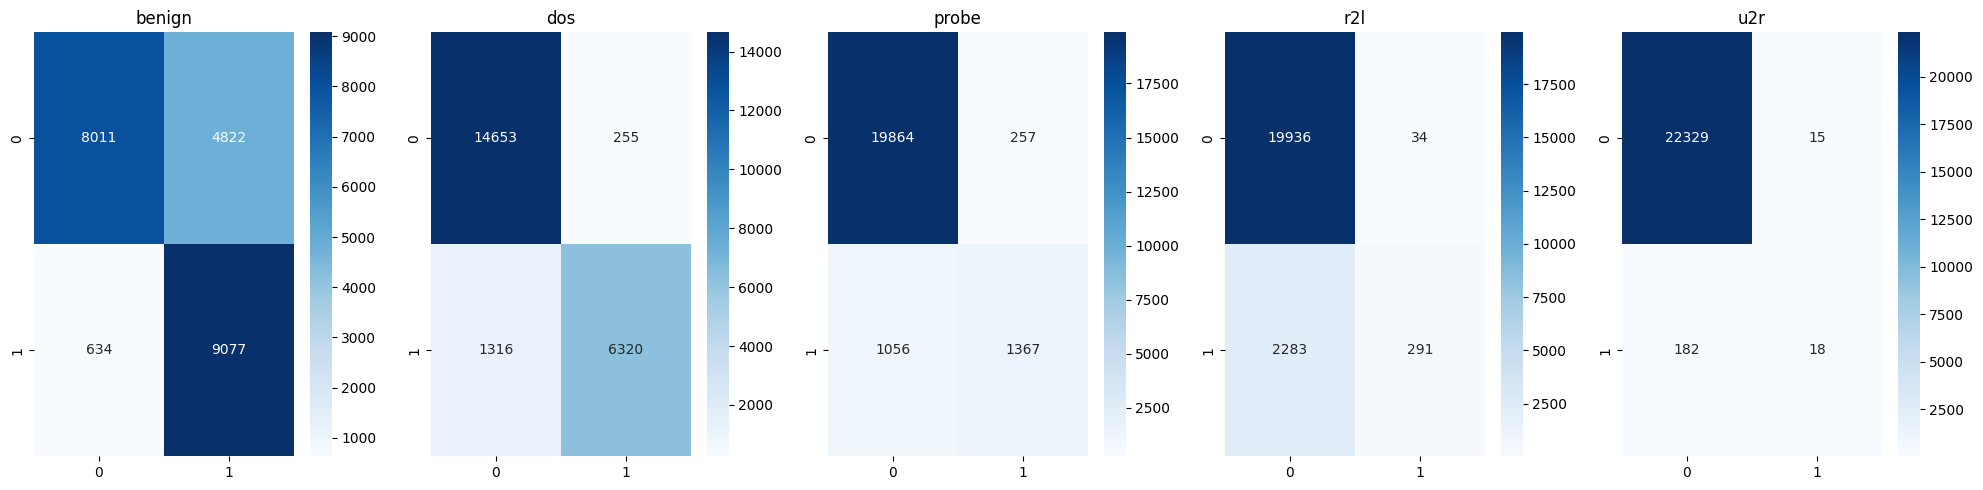

In [38]:
mlp_classifier = MLPClassifier(
    hidden_layer_sizes=(64, 32),
    activation='relu',
    solver='adam',
    alpha=0.0001,
    max_iter=100,
    random_state=42
)

mlp_classifier.fit(train_x, train_Y_encoded)
y_pred = mlp_classifier.predict(test_x)
print_analysis_report2(y_pred, mlp_classifier.__class__.__name__)

###Visualization Utilities

In [39]:
model_names = list(performance_metrics.keys())
accuracies = list(map(lambda x:x['accuracy'], performance_metrics.values()))
f1scores = list(map(lambda x:x['f1score'], performance_metrics.values()))
precisions = list(map(lambda x:x['precision'], performance_metrics.values()))
recalls = list(map(lambda x:x['recall'], performance_metrics.values()))
FARs = list(map(lambda x:x['FAR'], performance_metrics.values()))
models = list(map(lambda x:x, performance_metrics))
print(
  "\naccuracies", accuracies,
  "\nf1scores", f1scores,
  "\nprecisions", precisions,
  "\nrecalls", recalls,
  "\nFARs", FARs,
  "\nmodels:", list(performance_metrics.keys())
)


accuracies [0.755722143364088, 0.7584279630943932, 0.7621096522356281, 0.7619322214336409, 0.743124556422995] 
f1scores [0.5751300598759039, 0.5383925005210832, 0.5365861982591748, 0.5196654360220211, 0.5378381552428686] 
precisions [0.7619943418359932, 0.7955882223967755, 0.8363211675020017, 0.8601556370245385, 0.7793746450867961] 
recalls [0.5456508191748052, 0.516463977320082, 0.5124544931839992, 0.5063574671667119, 0.5059203850660385] 
FARs [0.417277435380881, 0.39363066304186334, 0.3799404957555059, 0.3705470994852931, 0.3936219881017352] 
models: ['LinearDiscriminantAnalysis', 'SVC', 'DecisionTreeClassifier', 'KNeighborsClassifier', 'MLPClassifier']


#Accuracy Comparision Graph

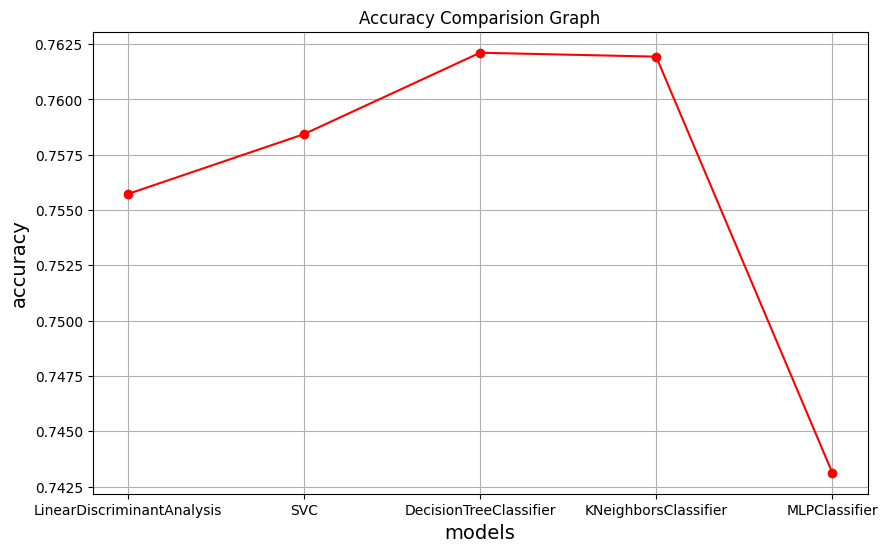

In [40]:
plt.figure(figsize=(10,6))
plt.plot(model_names, accuracies, color='red', marker='o')
plt.title('graph', fontsize=14)
plt.xlabel('models', fontsize=14)
plt.ylabel('accuracy', fontsize=14)
plt.title("Accuracy Comparision Graph")
plt.grid(True)
plt.show()

#F-Score Comparision Graph

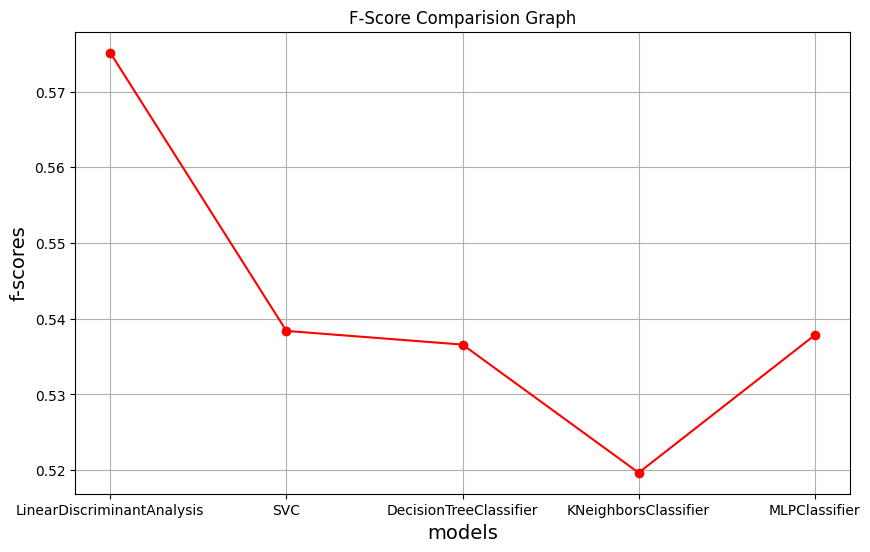

In [41]:
plt.figure(figsize=(10,6))
plt.plot(model_names, f1scores, color='red', marker='o')
plt.title('graph', fontsize=14)
plt.xlabel('models', fontsize=14)
plt.ylabel('f-scores', fontsize=14)
plt.title("F-Score Comparision Graph")
plt.grid(True)
plt.show()

#Precisions Comparision Graph

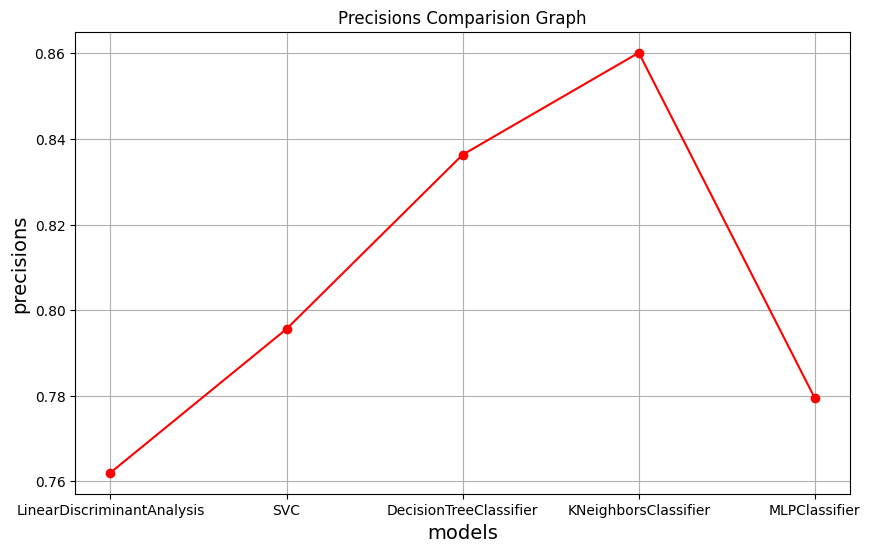

In [42]:
plt.figure(figsize=(10,6))
plt.plot(model_names, precisions, color='red', marker='o')
plt.title('graph', fontsize=14)
plt.xlabel('models', fontsize=14)
plt.ylabel('precisions', fontsize=14)
plt.title("Precisions Comparision Graph")
plt.grid(True)
plt.show()

#Re-Calls Comparision Graph

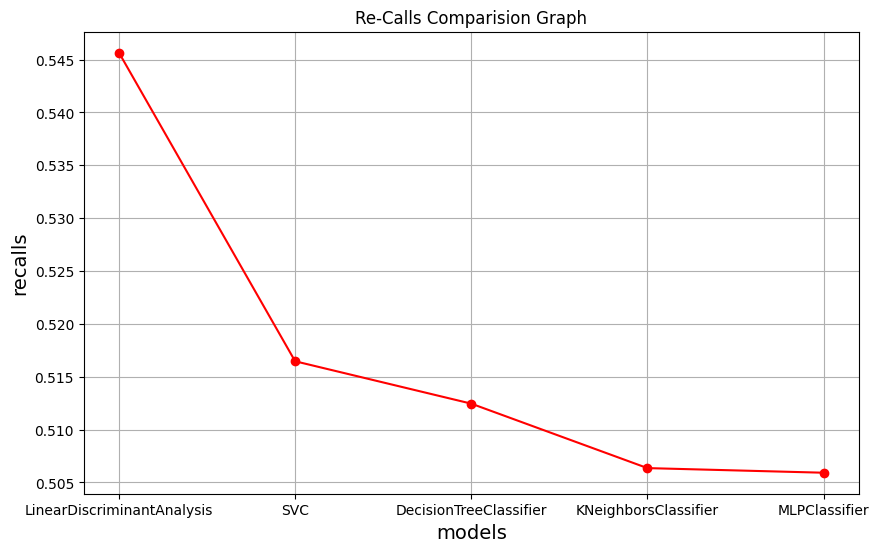

In [43]:
plt.figure(figsize=(10,6))
plt.plot(model_names, recalls, color='red', marker='o')
plt.title('graph', fontsize=14)
plt.xlabel('models', fontsize=14)
plt.ylabel('recalls', fontsize=14)
plt.title("Re-Calls Comparision Graph")
plt.grid(True)
plt.show()

#False Alarms Comparision Graph

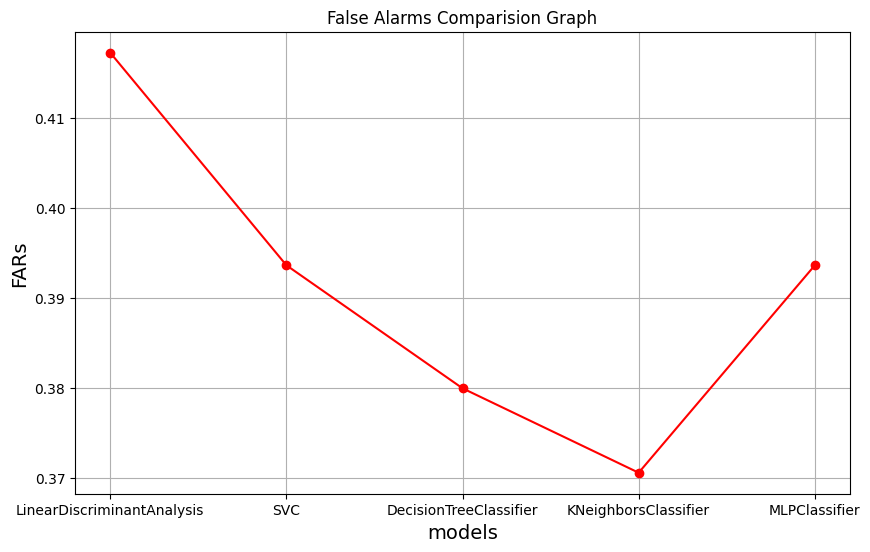

In [44]:
plt.figure(figsize=(10,6))
plt.plot(model_names, FARs, color='red', marker='o')
plt.title('graph', fontsize=14)
plt.xlabel('models', fontsize=14)
plt.ylabel('FARs', fontsize=14)
plt.title("False Alarms Comparision Graph")
plt.grid(True)
plt.show()

TypeError: ignored

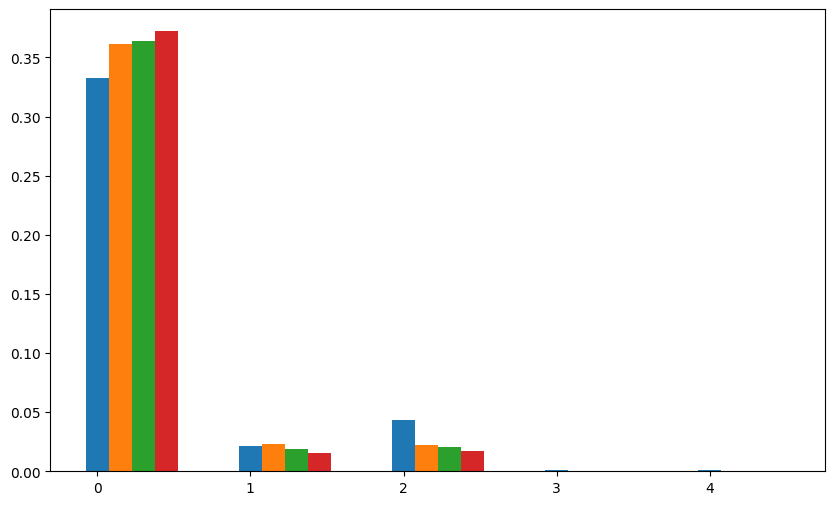

In [45]:
# categories = performance_metrics["A"]["class_FAR"].keys() # Categories is attack class
groups = performance_metrics.keys() # Group is your model name

# Define the width of the bars
bar_width = 0.15
plt.figure(figsize=(10,6))

# Create an array of equally spaced values for the x-axis
x = np.arange(len(label_names))

# Create the grouped bar chart
for i, model in enumerate(performance_metrics):
    plt.bar(x + i * bar_width, performance_metrics[model]["class_FAR"].values(), bar_width, label=model)

# Customize the chart
plt.xlabel('Models')
plt.ylabel('FAR Values')
plt.title('Class-wise False Alarm Rate Comparision Graph')
plt.xticks(x + bar_width * (len(groups) - 1) / 2, label_names)
plt.legend(fontsize=12)

# Display the chart
plt.tight_layout()
plt.show()

In [46]:
class_far_data = {key: value['class_FAR'] for key, value in performance_metrics.items()}

# Remove 'class_FAR' from the original data
for key in performance_metrics.keys():
    performance_metrics[key].pop('class_FAR')

# Convert the modified dictionary to a Pandas DataFrame
df = pd.DataFrame.from_dict(performance_metrics, orient='index')

# Convert the 'class_FAR' data to a separate Pandas DataFrame
df_class_far = pd.DataFrame.from_dict(class_far_data, orient='index')

# Display the two DataFrames
print("Table 1 - Main Data (Performance Metrics):")
print(df)
print("\nTable 2 - class_FAR Data:")
print(df_class_far)

Table 1 - Main Data (Performance Metrics):
                            accuracy   f1score  precision    recall       FAR
LinearDiscriminantAnalysis  0.755722  0.575130   0.761994  0.545651  0.417277
SVC                         0.758428  0.538393   0.795588  0.516464  0.393631
DecisionTreeClassifier      0.762110  0.536586   0.836321  0.512454  0.379940
KNeighborsClassifier        0.761932  0.519665   0.860156  0.506357  0.370547
MLPClassifier               0.743125  0.537838   0.779375  0.505920  0.393622

Table 2 - class_FAR Data:
                                                                       benign  \
LinearDiscriminantAnalysis                                           0.332502   
SVC                                                                  0.361256   
DecisionTreeClassifier                                               0.363983   
KNeighborsClassifier                                                 0.372166   
MLPClassifier               [0.04496135025884689, 0.07502

References:
- https://scikit-learn.org/stable/modules/model_evaluation.html